In [1]:
%matplotlib inline
from pprint import pprint
from decimal import Decimal
import itertools
import metrics
import pandas

import simulate
import harvesting
import market
import withdrawal
import numpy

In [42]:
import seaborn
from matplotlib import pyplot as plt
import matplotlib
seaborn.set(style="whitegrid")
seaborn.set_context('poster')

In [43]:
series = market.Returns_US_1871()

In [57]:
TYPE = 'Withdrawal (Real)'
m = {'Withdrawal (Nominal)': lambda x: float(x.withdraw_n),
     'Withdrawal (Real)' : lambda x: float(x.withdraw_r),
     'Portfolio (Nominal)': lambda x: float(x.portfolio_n),
     'Portfolio (Real)': lambda x: float(x.portfolio_r),
     'Stock %': lambda x: float(x.portfolio_post.stocks / x.portfolio_post.value_n)
}
lens = m[TYPE]
lens.__label__ = TYPE

def fn(x):
    return [lens(_) for _ in x]

In [47]:
class CourseCorrectHarvesting(harvesting.abc.HarvestingStrategy):
    _stock_ceiling = Decimal('1.2')

    def stock_increase(self):
        return self.portfolio.stocks / self.portfolio.starting_stocks_real

    def calc_to_sell(self):
        return self.portfolio.stocks / 5

    def do_harvest(self, amount):
        if self.stock_increase() > self._stock_ceiling:
            to_sell = self.calc_to_sell()
            self.portfolio.sell_stocks(to_sell)
            self.portfolio.buy_bonds(to_sell)

        # we've run out of bonds, rebalance the entire
        # portfolio back to 60/40
        if self.portfolio.bonds < 1:
            to_sell = self.portfolio.value / 5 * 2
            self.portfolio.sell_stocks(to_sell)
            self.portfolio.buy_bonds(to_sell)

        bond_amount = min(amount, self.portfolio.bonds)
        self.portfolio.sell_bonds(bond_amount)

        if self.portfolio.cash < amount:
            remainder = amount - self.portfolio.cash
            stock_amount = min(remainder, self.portfolio.stocks)
            self.portfolio.sell_stocks(stock_amount)


In [58]:
VPW_YEARS=40

def run_sim(year, length=30, h=harvesting.PrimeHarvesting):
    portfolio = (500000,500000)
#    harvest_strategy = harvesting.make_rebalancer(0.5)
    
    return simulate.withdrawals(series.iter_from(year),
                                 withdraw=withdrawal.EM,
                                 years=length,
                                 portfolio=portfolio,
                                 harvesting=h)

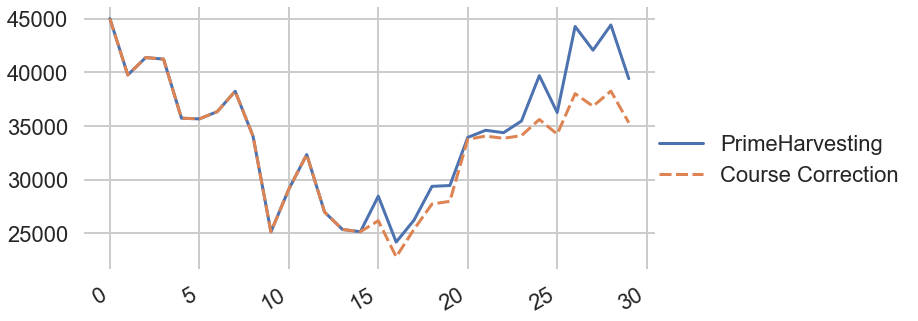

In [60]:
df = pandas.DataFrame(
    {
        'PrimeHarvesting' : [lens(x) for x in run_sim(1966)],
        'Course Correction' : [lens(x) for x in run_sim(1966, h=CourseCorrectHarvesting)]
    }
)
g = seaborn.relplot(
        data=df,
        kind='line',
        aspect=2,
    )
g.fig.autofmt_xdate()
g.despine(left=True, bottom=True, offset=20)
#g.fig.suptitle(f'Retirement in {year}')

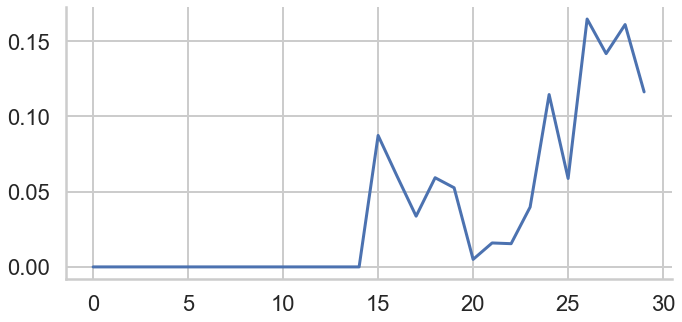

In [66]:
s = df['PrimeHarvesting'] / df['Course Correction'] - 1
g = seaborn.relplot(
        data=s,
        kind='line',
        aspect=2,
    )